In [27]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [28]:
from scipy.stats import chi2


In [29]:
global_rng = np.random.default_rng(50)

In [30]:
def construct_cov_mtx(var_x: float, var_y: float, rho: float) -> np.ndarray:
	cov_xy = rho * np.sqrt(var_x * var_y)
	return np.array([[var_x, cov_xy],
					 [cov_xy, var_y]])


def simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points, rng=global_rng):
	if rng is None:
		rng = np.random.default_rng()
	cov = construct_cov_mtx(var_x, var_y, rho)
	data = rng.multivariate_normal([mu_x, mu_y], cov, size=n_points)
	x, y = data[:, 0], data[:, 1]
	return x, y

def add_gaussian_noise(x, y, noise_var, m=0, rng=global_rng):
	if rng is None:
		rng = np.random.default_rng()
	sd = np.sqrt(noise_var * m)
	x_noisy = x + rng.normal(0, sd, size=x.shape)
	y_noisy = y + rng.normal(0, sd, size=y.shape)
	return x_noisy, y_noisy



In [31]:
def tls_regression(x_vals, y_vals):
	"""Compute Total Least Squares (orthogonal) regression slope and intercept."""
	x_mean, y_mean = x_vals.mean(), y_vals.mean()
	Sxx = np.sum((x_vals - x_mean)**2)
	Syy = np.sum((y_vals - y_mean)**2)
	Sxy = np.sum((x_vals - x_mean)*(y_vals - y_mean))
	# TLS slope formula
	slope = (Syy - Sxx + np.sqrt((Sxx - Syy)**2 + 4*Sxy**2)) / (2*Sxy)
	intercept = y_mean - slope * x_mean
	return slope, intercept

In [32]:
def plot_population_covariance(mu_x, mu_y, var_x, var_y, rho, ax=None, 
								m_scaling = 0.68,
								xlim=(-0.5, 1.0),
								ylim=(2, 4),
								xtick_step=0.5,
								ytick_step=0.5,
								xlabel='Variable X',
								ylabel='Variable Y',
							   annotate=True, n_points=1000):
	"""
	Plot the covariance ellipse for a 2D Gaussian defined by:
	  mean = (mu_x, mu_y)
	  covariance = [[var_x, rho*sqrt(var_x*var_y)],
					[rho*sqrt(var_x*var_y), var_y]]
	 68% ellipse by default (1 std dev).

	Parameters
	----------
	mu_x, mu_y : float
		Means of x and y.
	var_x, var_y : float
		Variances of x and y. Must be >= 0.
	rho : float
		Correlation coefficient between x and y. Should be in [-1, 1].
	ax : matplotlib.axes.Axes or None
		If provided, plot into this axis. Otherwise create a new figure/axis.
	n_points : int
		Number of points used to draw the ellipse curve.

	Returns
	-------
	fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
		Handles to the created/used figure and axis.
	"""
	# ---- Basic input checks ----
	if var_x < 0 or var_y < 0:
		raise ValueError("var_x and var_y must be non-negative.")
	if not (-1.0 <= rho <= 1.0):
		raise ValueError("rho must be between -1 and 1.")

	# Guard against tiny negative due to floating error
	sx = np.sqrt(max(var_x, 0.0))
	sy = np.sqrt(max(var_y, 0.0))

	# ---- Build the covariance matrix from variances + correlation ----
	Sigma = construct_cov_mtx(sx, sy, rho)

	# ---- Eigen-decomposition: directions (evecs) and variances along them (evals) ----
	# eigh is for symmetric matrices; returns sorted eigenvalues ascending
	evals, evecs = np.linalg.eigh(Sigma)
	# Ensure ascending -> (small, large); we’ll name them explicitly
	lam_small, lam_large = evals[0], evals[1]
	vec_small, vec_large = evecs[:, 0], evecs[:, 1]   # columns are eigenvectors

	# ---- 95% scaling for a 2D Gaussian (Mahalanobis radius) ----
	chisquare_val = np.sqrt(chi2.ppf(m_scaling, df=2)) #for 95%, chisquare_val=2.4477

	# Semi-axis lengths
	a = chisquare_val * np.sqrt(max(lam_large, 0.0))  # major axis
	b = chisquare_val * np.sqrt(max(lam_small, 0.0))  # minor axis

	# ---- Parametric ellipse in its own coordinate frame (axis-aligned) ----
	theta = np.linspace(0.0, 2.0 * np.pi, n_points)
	ellipse_local = np.column_stack([a * np.cos(theta),
									 b * np.sin(theta)])  # (n_points, 2)

	# ---- Rotate ellipse to match covariance orientation ----
	# The major eigenvector gives the direction of the major axis.
	# Using it directly as a rotation basis is clean: rotate by multiplying with eigenvectors.
	# If we build a basis matrix B = [vec_large vec_small], then local coords -> world coords:
	B = np.column_stack([vec_large, vec_small])  # (2,2)
	ellipse_world = ellipse_local @ B.T          # (n_points, 2)

	# ---- Translate ellipse to the mean ----
	ellipse_world[:, 0] += mu_x
	ellipse_world[:, 1] += mu_y

	# ---- Plot ----
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 6))
	else:
		fig = ax.figure

	ax.plot(ellipse_world[:, 0], ellipse_world[:, 1], linewidth=2)
	ax.scatter([mu_x], [mu_y], s=40)  # mark the center


	# --- annotations (matched exactly) ---
	if annotate:
		ax.text(0.05, 0.97, rf'$\rho = {rho:.2f}$',
				transform=ax.transAxes, va='top',
				fontsize=22, color='black')

	# --- axes formatting (copied verbatim) ---
	ax.set_xlim(*xlim)
	ax.set_ylim(*ylim)
	ax.set_xlabel(xlabel, fontsize=22)
	ax.set_ylabel(ylabel, fontsize=22)

	ax.set_xticks(np.arange(xlim[0], xlim[1] + 1e-9, xtick_step))
	ax.set_yticks(np.arange(ylim[0], ylim[1] + 1e-9, ytick_step))
	ax.tick_params(axis='both', which='major', labelsize=22)


	return fig, ax


In [33]:
def plot_scatter_with_tls(
	x, y, param_legend,
	rho=None,                      # for annotation
	ax=None,
	xlim=(-0.5, 1),
	ylim=(2, 4),
	xtick_step=0.5,
	ytick_step=0.5,
	xlabel='Variable X',
	ylabel='Variable Y',
	point_size=90,
	alpha=0.6,
	line_n=200,
	line_label='TLS fit',
	annotate=True,
):
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 6))

	slope, intercept = tls_regression(x, y)
	r_value, _ = pearsonr(x, y)

	ax.scatter(x, y, s=point_size, alpha=alpha, color='cornflowerblue')

	# Draw fitted line over the visible x-range
	x_line = np.linspace(xlim[0], xlim[1], line_n)
	ax.plot(x_line, slope * x_line + intercept, linewidth=2, label=line_label, color='slategrey')

	if annotate:
		ax.text(0.05, 0.97, param_legend,
				transform=ax.transAxes, va='top', fontsize=22, color='black')
		ax.text(0.05, 0.89, rf'$r = {r_value:.2f}$',
				transform=ax.transAxes, va='top', fontsize=22, color='royalblue')		
		if rho is not None:
			ax.text(0.05, 0.81, rf'$\rho = {rho:.2f}$',
					transform=ax.transAxes, va='top', fontsize=22, color='black')


	ax.set_xlim(*xlim)
	ax.set_ylim(*ylim)
	ax.set_xlabel(xlabel, fontsize=22)
	ax.set_ylabel(ylabel, fontsize=22)

	ax.set_xticks(np.arange(xlim[0], xlim[1] + 1e-9, xtick_step))
	ax.set_yticks(np.arange(ylim[0], ylim[1] + 1e-9, ytick_step))
	ax.tick_params(axis='both', which='major', labelsize=22)

	return ax


In [34]:
def simulate_r_over_sweep(
	sweep_values,
	simulate_fn,   # function: (val, rng) -> (x, y)
	measure_fn,    # function: (x, y, val, rng) -> (x_meas, y_meas)
	example_datasets_points=[],
	n_traces=100,
	rng=global_rng,
):
	"""Run repeated simulations and return r traces over a swept parameter."""
	if rng is None:
		rng = np.random.default_rng()

	sweep_values = np.asarray(sweep_values)
	results = np.empty((n_traces, sweep_values.size), dtype=float)
	example_datasets = []

	for t in range(n_traces):
		for idx, val in enumerate(sweep_values):
			x, y = simulate_fn(val, rng)
			x_meas, y_meas = measure_fn(x, y, val, rng)
			r, _ = pearsonr(x_meas, y_meas)
			results[t, idx] = r
			if t == 0 and val in example_datasets_points:
				example_datasets.append((val, x_meas, y_meas))


	return results, example_datasets


In [35]:
def plot_traces(
	x_values,
	results,
	rho,
	xlabel,
	ylabel=rf"Pearson's $r$",
	true_r=0.6,
	xscale='log',
	figsize=(18, 4),
	yticks=(0, 0.6, 1),
	ylim=(-0.4, 1.1),
	xlim=None,
	fontsize=22,
):
	"""Plot simulation traces"""
	plt.figure(figsize=figsize)

	for t in range(results.shape[0]):
		if t == 0:
			plt.plot(
				x_values,
				results[t],
				color='cornflowerblue',
				alpha=1.0,
				linewidth=3,
				zorder=3,
			)
		else:
			plt.plot(
				x_values,
				results[t],
				color='lightgray',
				alpha=0.7,
				linewidth=2,
				zorder=1,
			)

	plt.axhline(true_r, color='black', ls='--', label='True R')
	plt.xlabel(xlabel, size=fontsize)
	plt.ylabel(ylabel, size=fontsize)

	plt.xticks(size=fontsize)
	plt.yticks(list(yticks), size=fontsize)

	if xscale is not None:
		plt.xscale(xscale)

	if xlim is not None:
		plt.xlim(*xlim)

	plt.ylim(*ylim)

	ax = plt.gca()
	ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
	ax.tick_params(axis='x', labelsize=fontsize)

	plt.text(0.02, 0.97, rf'$\rho = {rho}$',
			 transform=ax.transAxes, va='top', fontsize=fontsize, color='black')

	plt.tight_layout()
	plt.show()


In [36]:
def average_repeats(x, y, n_repeats, noise_var, m=1.0, rng=None):
	if rng is None:
		rng = np.random.default_rng()

	n_points = x.shape[0]
	x_rep = np.empty((n_repeats, n_points))
	y_rep = np.empty((n_repeats, n_points))

	for i in range(n_repeats):
		x_rep[i], y_rep[i] = add_gaussian_noise(x, y, noise_var=noise_var, m=m, rng=rng)

	return x_rep.mean(axis=0), y_rep.mean(axis=0)


## SAMPLING

In [37]:
mu_x = 0.25
mu_y = 2.9
var_x = 0.025
var_y = 0.06
rho = 0.6

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Variable X', ylabel='Variable Y'>)

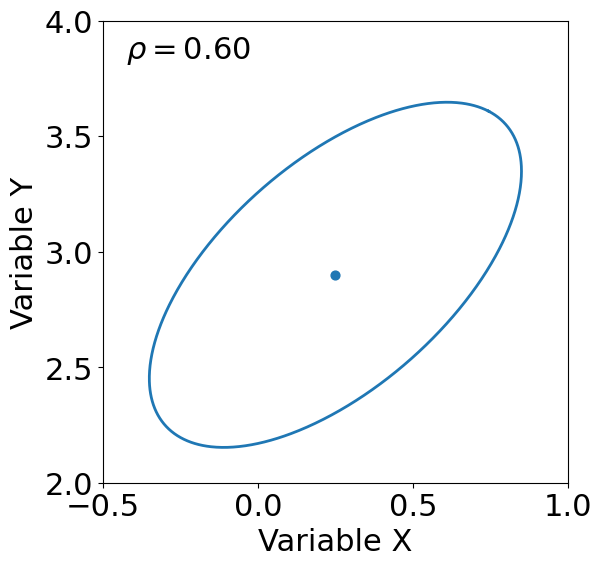

In [38]:
plot_population_covariance(
	mu_x=mu_x,
	mu_y=mu_y,
	var_x=var_x,
	var_y=var_y,
	rho=rho
)


In [39]:
# for n_points in [10, 100, 1000]:
# 	x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points)
# 	ax = plot_scatter_with_tls(x, y, param_legend=r'$N$ = {}'.format(n_points), rho=rho)
# 	# ax.set_title(f'N = {n_points}', fontsize=18)
# 	plt.show()


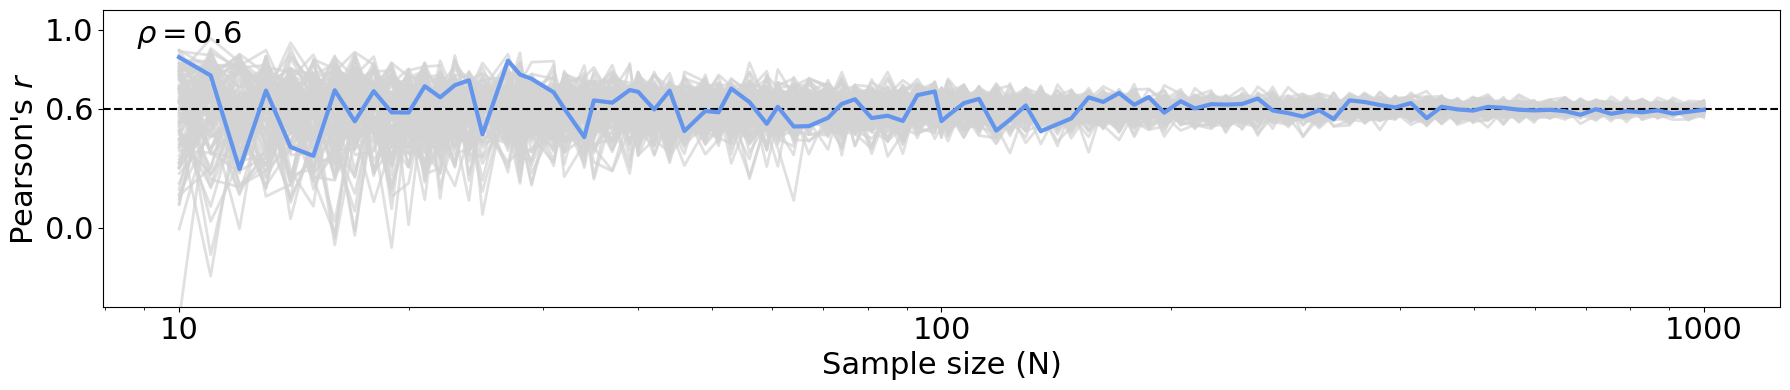

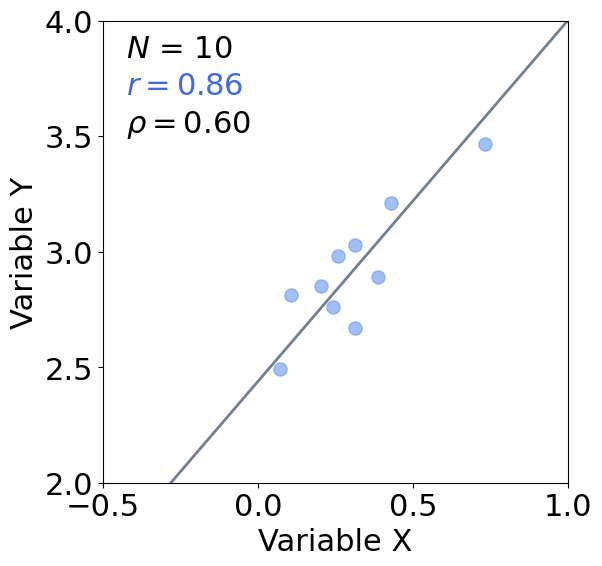

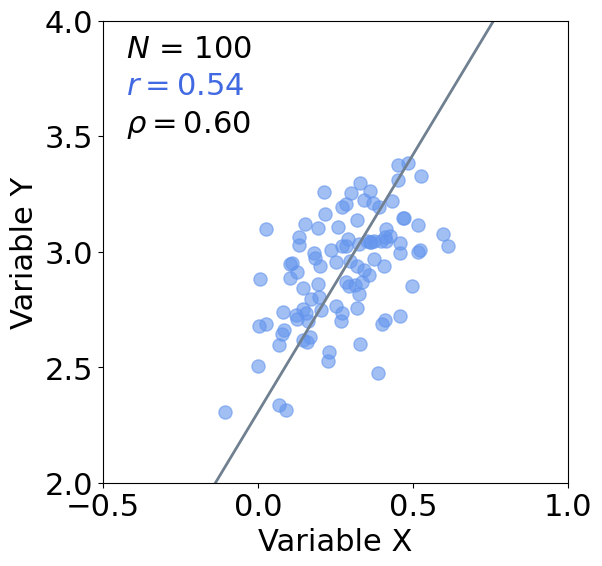

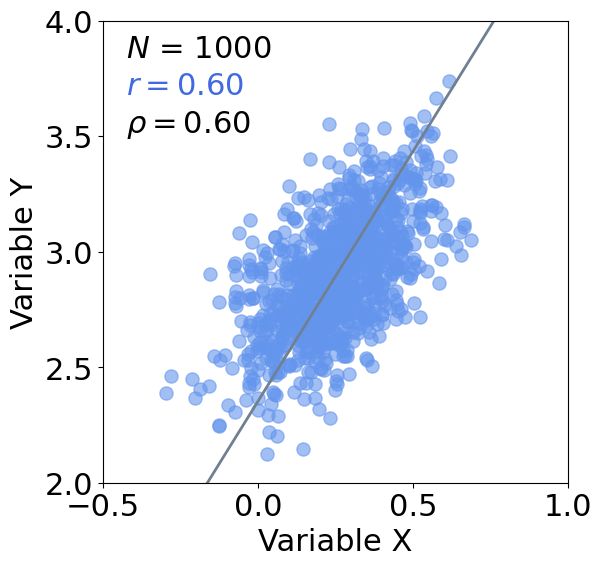

In [40]:
def simulate_by_N(N, rng):
	return simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=int(N), rng=rng)

def measure_identity(x, y, N, rng):
	return x, y

def measure_with_noise(x, y, N, rng):
	return add_gaussian_noise(x, y, noise_var=0.06, m=1.0, rng=rng)

sample_sizes = np.logspace(1, 3, num=90).round().astype(int)
sample_sizes = np.unique(
    np.concatenate([
        np.logspace(1, 3, num=100).round().astype(int),
        [10, 100, 1000],
    ])
)


results_true, example_datasets_true = simulate_r_over_sweep(sample_sizes, simulate_by_N, measure_identity,
															example_datasets_points=[10, 100, 1000])
plot_traces(sample_sizes, results_true, rho=rho, xlabel='Sample size (N)', fontsize=22)
for N, x, y in example_datasets_true:
	ax = plot_scatter_with_tls(
		x, y,
		param_legend=rf'$N$ = {N}',
		rho=rho
	)
	plt.show()
# results_noisy = simulate_r_over_sweep(sample_sizes, simulate_by_N, measure_with_noise)
# plot_traces(sample_sizes, results_noisy, rho=rho, xlabel='Sample size (N)', fontsize=22)


## NOISE

In [41]:
# # Parameters
# var_x, var_y, noise_var = 0.06, 0.06, 0.06

# # Base data once
# x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=10, rng=global_rng)

# # Plot: original + different noise multipliers
# for m, title in [(0.0, 'Original'), (0.1, 'Moderate noise'), (1.0, 'High noise')]:
# 	if m == 0.0:
# 		x_plot, y_plot = x, y
# 	else:
# 		x_plot, y_plot = add_gaussian_noise(x, y, noise_var, m=m, rng=global_rng)

# 	ax = plot_scatter_with_tls(x_plot, y_plot, param_legend=r'$N$ = {}'.format(m), rho=rho)
# 	ax.set_title(title, fontsize=18)
# 	plt.show()

In [42]:
# noise_levels = np.logspace(-2, 0.2, num=100)

# def simulate_fixed_N(noise_level, rng):
# 	return simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=100, rng=rng)

# def measure_noise_sweep(x, y, noise_level, rng):
# 	return add_gaussian_noise(x, y, noise_var=float(noise_level), m=1.0, rng=rng)

# results, example_datasets = simulate_r_over_sweep(noise_levels, simulate_fixed_N, measure_noise_sweep)
# plot_traces(noise_levels, results, rho=rho, xlabel='Noise level', xscale='log', fontsize=22)


# MEANS

In [43]:
# Parameters
mu_x = 0.25
mu_y = 2.9
var_x = 0.025
var_y = 0.06
rho = 0.6
noise_var = 0.1
# var_x, var_y, noise_var, rho = 0.06, 0.06, 0.1, 0.6
n_points = 60
m = 1.0

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Variable X', ylabel='Variable Y'>)

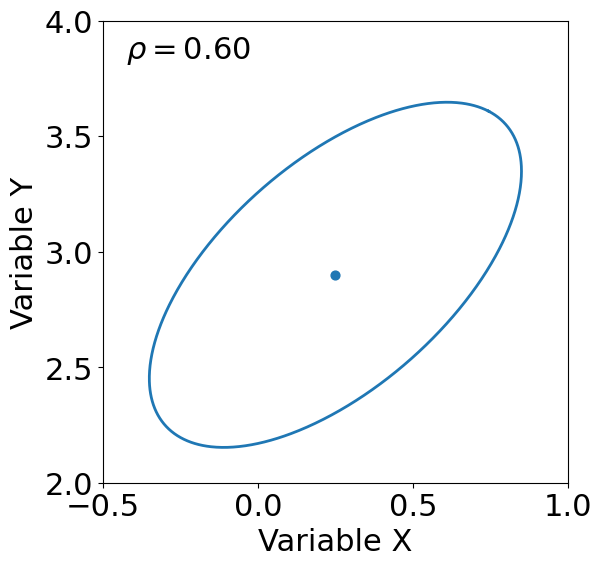

In [44]:
plot_population_covariance(
	mu_x=mu_x,
	mu_y=mu_y,
	var_x=var_x,
	var_y=var_y,
	rho=rho
)

In [45]:

# Base data once
# x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=global_rng)
# # Plot: averaged over different numbers of repeats
# for n_repeats in [1, 10, 100]:
# 	x_mean, y_mean = average_repeats(x, y, n_repeats=n_repeats, noise_var=noise_var, m=m, rng=global_rng)

# 	ax = plot_scatter_with_tls(x_mean, y_mean, param_legend=r'$N$ = {}'.format(n_repeats), rho=rho)
# 	# ax.set_title(f'{n_repeats} repeated measurements (averaged)', fontsize=18)
# 	plt.show()

In [46]:
# # --- parameters ---
# mu_x, mu_y = 0.25, 2.9
# var_x, var_y, noise_var = 0.06, 0.06, 0.1
# rho = 0.6
# m = 1.0

# num_thresholds = np.array([1, 2, 4, 6, 8, 10, 20, 40, 80, 100])

# n_traces = 100
# max_T = int(num_thresholds.max())
# n_points = 200

# results_raw = np.empty((n_traces, num_thresholds.size))

# for t in range(n_traces):
# 	# underlying true x,y once per trace
# 	x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=global_rng)

# 	# generate all repeats
# 	x_reps = np.empty((max_T, n_points))
# 	y_reps = np.empty((max_T, n_points))
# 	for k in range(max_T):
# 		x_reps[k], y_reps[k] = add_gaussian_noise(x, y, noise_var=noise_var, m=m, rng=global_rng)

# 	# sweep by taking the first T repeats
# 	for idx, thresh in enumerate(num_thresholds):
# 		xs = x_reps[:thresh]
# 		ys = y_reps[:thresh]
# 		raw_r, _ = pearsonr(xs.mean(axis=0), ys.mean(axis=0))
# 		results_raw[t, idx] = raw_r

# colors = 'lightgrey'
# curves = [results_raw[t] for t in range(n_traces)]
# styles = [dict(linestyle='-', color=colors[t % len(colors)], alpha=1.0) for t in range(n_traces)]

# plot_r_curves(num_thresholds, curves, labels=[None]*n_traces, styles=styles, true_r=rho)


In [47]:
def make_simulate_fn_thresholds(mu_x, mu_y, var_x, var_y, rho, n_points):
    """simulate_fn(T, rng) -> (x, y). Here val=T is ignored for latent truth."""
    def simulate_fn(T, rng):
        # latent (true) observer values; same size regardless of T
        x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=rng)
        return x, y
    return simulate_fn


def make_measure_fn_thresholds(noise_var, m=1.0):
    """measure_fn(x, y, T, rng) -> (x_avg, y_avg) by averaging T noisy repeats."""
    def measure_fn(x, y, T, rng):
        T = int(T)
        # generate T repeats and average
        x_sum = np.zeros_like(x, dtype=float)
        y_sum = np.zeros_like(y, dtype=float)
        for _ in range(T):
            x_noisy, y_noisy = add_gaussian_noise(x, y, noise_var=noise_var, m=m, rng=rng)
            x_sum += x_noisy
            y_sum += y_noisy
        return x_sum / T, y_sum / T
    return measure_fn


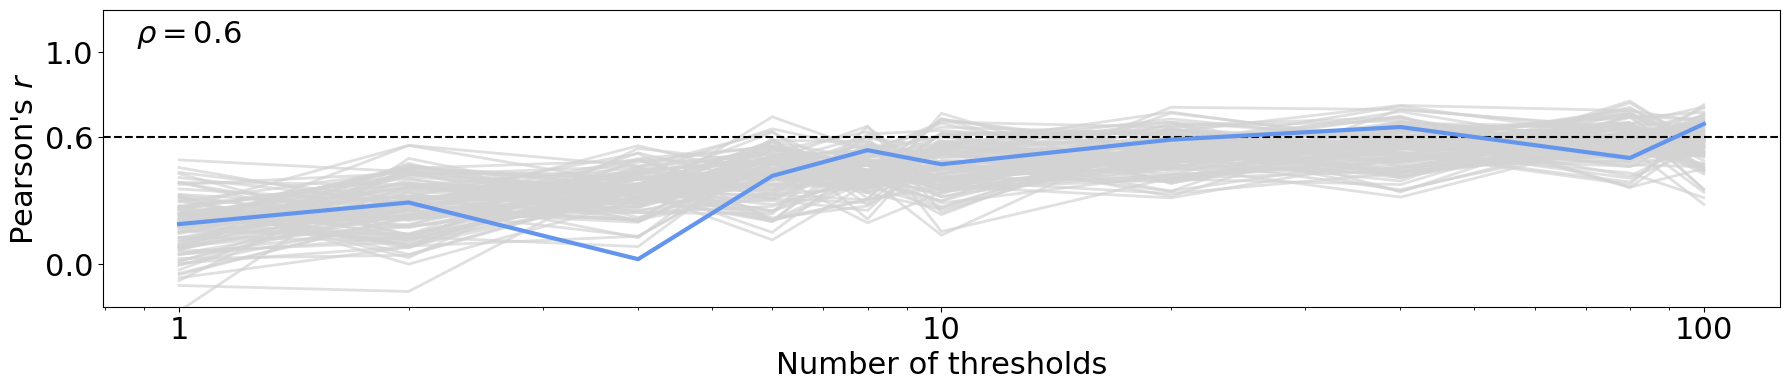

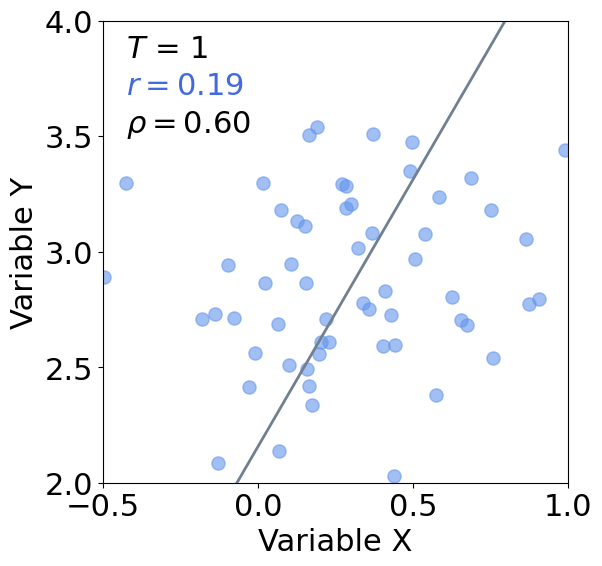

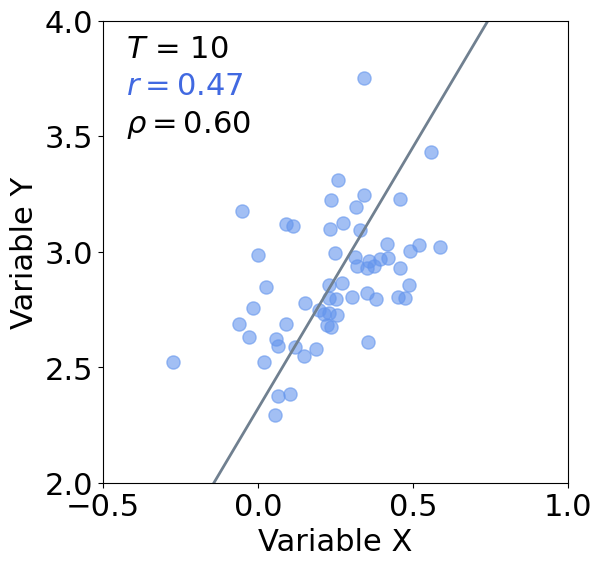

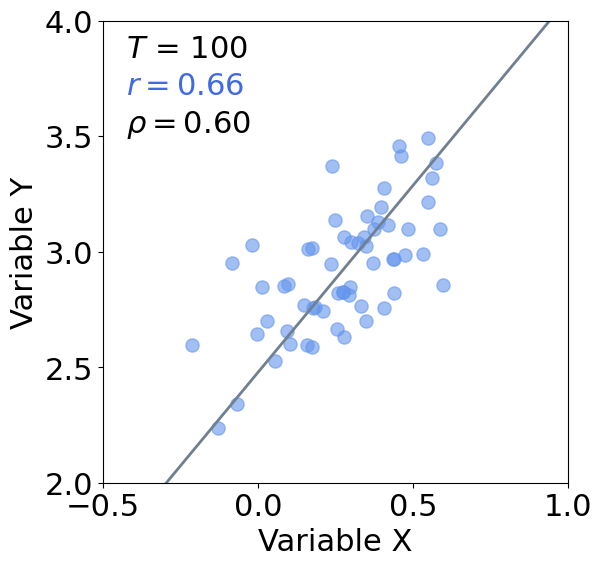

In [48]:
num_thresholds = np.array([1, 2, 4, 6, 8, 10, 20, 40, 80, 100])

simulate_fn = make_simulate_fn_thresholds(mu_x, mu_y, var_x, var_y, rho, n_points=n_points)
measure_fn  = make_measure_fn_thresholds(noise_var=noise_var, m=m)

results, examples = simulate_r_over_sweep(
    num_thresholds,
    simulate_fn=simulate_fn,
    measure_fn=measure_fn,
    example_datasets_points=[1, 10, 100],
    n_traces=100,
    rng=global_rng,
)

plot_traces(
    num_thresholds,
    results,
    rho=rho,
    xlabel="Number of thresholds",
    true_r=rho,          
    xscale="log",
    ylim=(-0.2, 1.2),
    yticks=(0, 0.6, 1),
    fontsize=22,
)
for T, x_ex, y_ex in examples:
    plot_scatter_with_tls(x_ex, y_ex, param_legend=rf'$T$ = {T}', rho=rho)
    plt.show()
